In [1]:
## Trying to fix the shortcommings of notebook 1 by scaling the samples :>

In [2]:
import numpy as np
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import torch

import torch.nn as nn

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing the Dataset

In [3]:
files = glob.glob("../Data/*.npy")
files.sort()

In [4]:
g = list(map(lambda x: float(x.split("_")[1]),files))
unique_g = list(set(g))

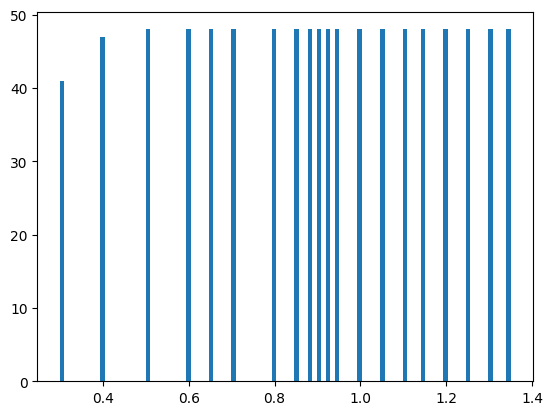

In [5]:
plt.hist(g,bins = 100)
plt.show()

In [6]:
G = []
L = []
for idx in tqdm(range(len(unique_g))):
    ids = np.where(np.array(g) == unique_g[idx])[0].tolist()
    l = []
    for id_ in ids:
        l.append(np.load(files[id_]))
    array = np.concatenate(l,-1)
    array = np.reshape(array,(16,16,-1))
    array = np.transpose(array,(-1,0,1))
    G.append(np.ones((array.shape[0],1))*unique_g[idx])
    L.append(array)

100%|██████████| 20/20 [00:01<00:00, 13.75it/s]


In [7]:
LATTICE = np.concatenate(L,0)
G = np.concatenate(G,0)

In [8]:
indices = np.arange(0,LATTICE.shape[0]).tolist()
random.shuffle(indices)
LATTICE = LATTICE[indices]
G = G[indices]

In [9]:
# np.save("./Dataset/test_L",LATTICE)
# np.save("./Dataset/test_G",G)

# Analysing the Dataset

Text(0, 0.5, 'Number of Configurations')

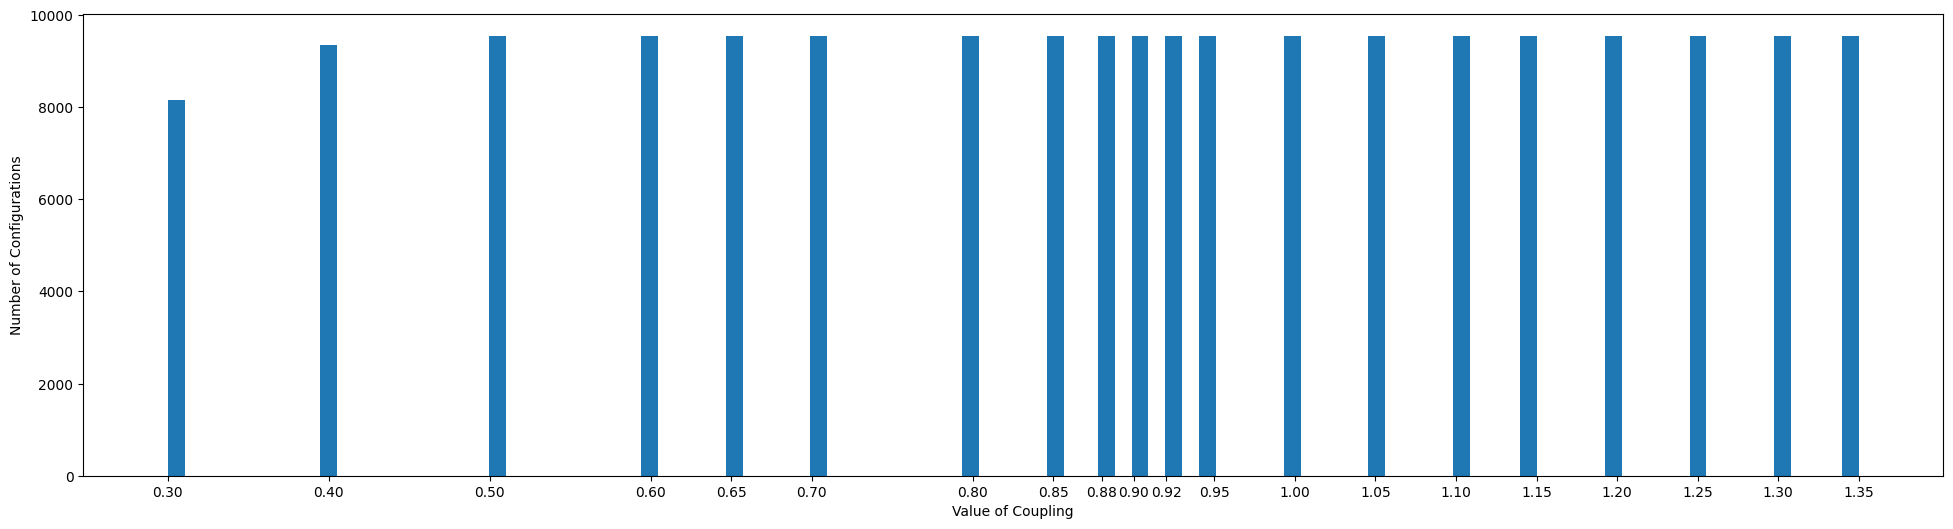

In [10]:
plt.figure(figsize=(24,6))
plt.hist(G,bins = 100)
plt.xticks(unique_g)
plt.xlabel("Value of Coupling")
plt.ylabel("Number of Configurations")

In [11]:
g = []
g_inv_2 = []
sigma_mean = []
sigma_error = []
unique_g.sort()
for idx in range(len(unique_g)):
    idx_g = np.where(G == unique_g[idx])[0]
    lattice_g  = LATTICE[idx_g,:,:]
    mean_sigma = lattice_g.mean()
    err_sigma = (lattice_g.mean((1,2)).std())
    
    g.append(unique_g[idx])
    g_inv_2.append(1/(unique_g[idx]**2))
    sigma_mean.append(mean_sigma)
    sigma_error.append(err_sigma)

Text(0.5, 1.0, 'Sigma vs Coupling g')

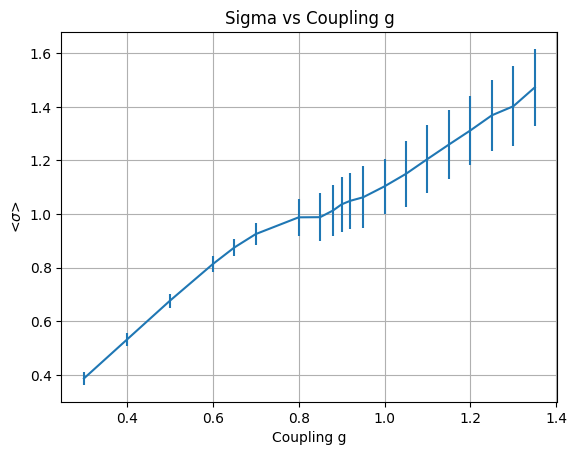

In [12]:
plt.errorbar(x = g,y=sigma_mean,yerr=sigma_error)
plt.xlabel("Coupling g")
plt.ylabel("<$\sigma$>")
plt.grid()
plt.title("Sigma vs Coupling g")

Text(0.5, 1.0, 'Sigma vs $1/{g^2}$')

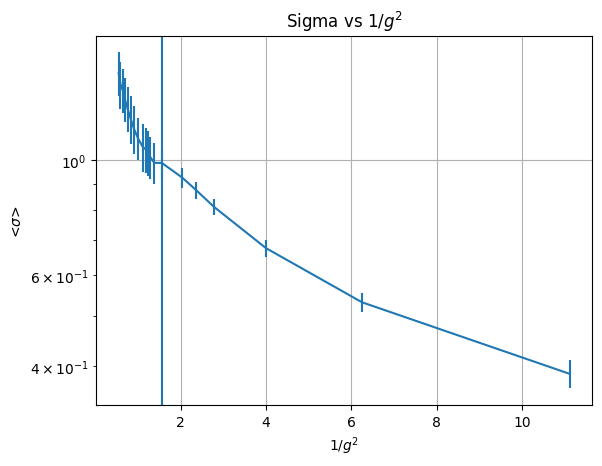

In [13]:
plt.errorbar(x = g_inv_2,y=sigma_mean,yerr=sigma_error)
plt.xlabel("$1/{g^2}$")
plt.ylabel("<$\sigma$>")

plt.axvline(1.5624)
plt.yscale("log")
plt.grid()
plt.title("Sigma vs $1/{g^2}$")

# Transforming the input data to make it suitable for GAN 

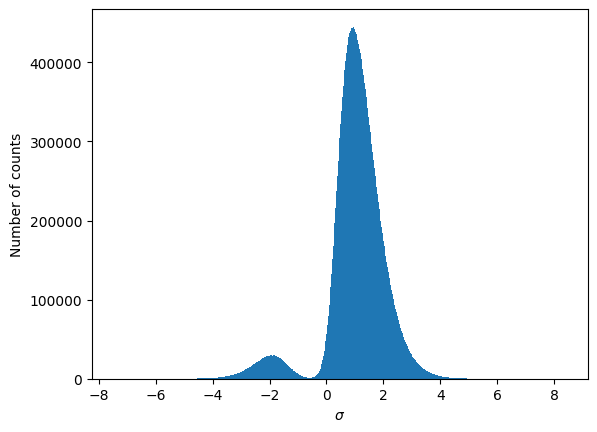

In [14]:
# Taking a look at the distribution of the input data before scaling every thing
plt.hist(LATTICE.ravel(), bins = 1000)
plt.xlabel("$\sigma$")
plt.ylabel("Number of counts")
plt.show()


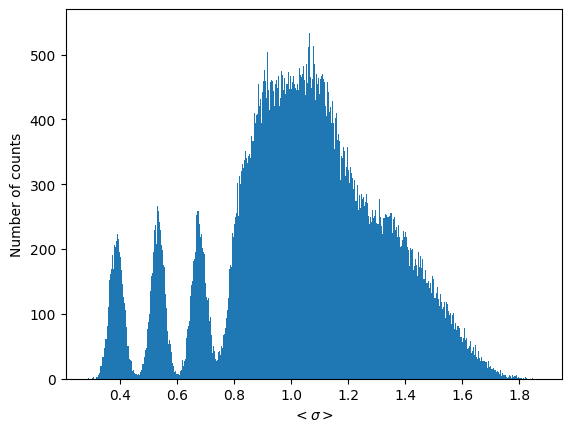

In [15]:
plt.hist(LATTICE.mean((-1,-2)).ravel(), bins = 1000)
plt.xlabel("$<\sigma>$")
plt.ylabel("Number of counts")
plt.show()

## Using the transformative field discussed in Singha et al.
## $\sigma^{p}(x) = ln(\sigma(x)+c)$
## $c$ is such that the sum $\sigma(x)+c$ is positive
## Finally we scale the data in the range [-1,1]

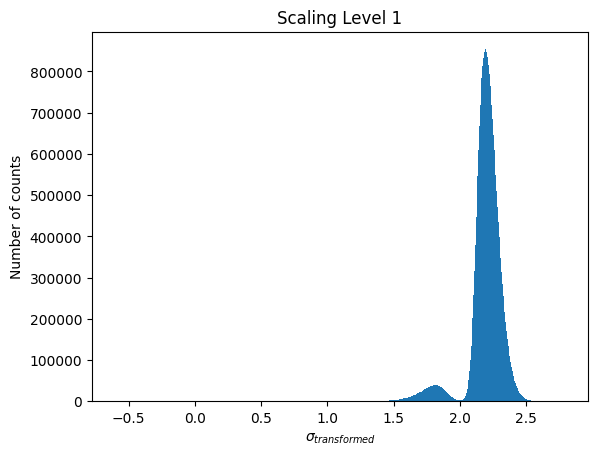

In [16]:
LATTICE_transformed = np.log(LATTICE + 8)
plt.hist(LATTICE_transformed.ravel(), bins = 1000)
plt.xlabel("$\sigma_{transformed}$")
plt.ylabel("Number of counts")
plt.title("Scaling Level 1")
plt.show()

## Still the data has a lot of outlier which is throwing off our GAN. We will clip everthing above 

0.02527491052953845 % of the points clipped


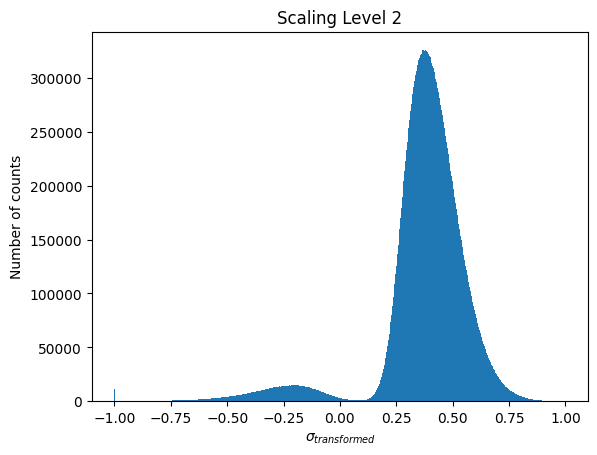

In [17]:
clip = [1.3,2.6]

exclusion_ratio = (np.where((LATTICE_transformed.ravel() < clip[0])+(LATTICE_transformed.ravel() > clip[1]))[0].shape[0])/LATTICE_transformed.ravel().shape[0]
print(f"{exclusion_ratio*100} % of the points clipped")
LATTICE_clipped = np.clip(LATTICE_transformed,a_max=clip[1],a_min=clip[0])
L_min = LATTICE_clipped.min()
L_max = LATTICE_clipped.max()
LATTICE_scaled = 2*(LATTICE_clipped-L_min)/(L_max-L_min) - 1
plt.hist(LATTICE_scaled.ravel(), bins = 1000)
plt.xlabel("$\sigma_{transformed}$")
plt.ylabel("Number of counts")
plt.title("Scaling Level 2")
plt.show()

In [18]:
g = []
g_inv_2 = []
sigma_mean = []
sigma_error = []
unique_g.sort()
for idx in range(len(unique_g)):
    idx_g = np.where(G == unique_g[idx])[0]
    lattice_g  = LATTICE_scaled[idx_g,:,:]
    mean_sigma = lattice_g.mean()
    err_sigma = (lattice_g.mean((1,2)).std())
    
    g.append(unique_g[idx])
    g_inv_2.append(1/(unique_g[idx]**2))
    sigma_mean.append(mean_sigma)
    sigma_error.append(err_sigma)

Text(0.5, 1.0, 'Sigma vs $1/{g^2}$ for the scaled lattice')

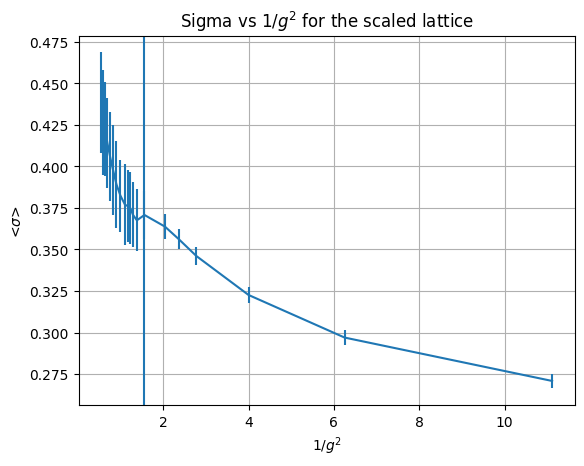

In [19]:
plt.errorbar(x = g_inv_2,y=sigma_mean,yerr=sigma_error)
plt.xlabel("$1/{g^2}$")
plt.ylabel("<$\sigma$>")

plt.axvline(1.5624)
plt.grid()
plt.title("Sigma vs $1/{g^2}$ for the scaled lattice")

## Physics remains unchanged :>

# Preparing the Discriminators and Generators

In [20]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.pad = nn.CircularPad2d(1)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.layer1 = nn.Conv2d(in_channels=2,
                                out_channels=32,
                                kernel_size=(3,3),
                                stride=(2,2))
        
        self.layer2 = nn.Conv2d(in_channels=32,
                                out_channels=64,
                                kernel_size=(3,3),
                                stride=(2,2))
        

        self.layer3 = nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(4,4),
                                stride=(1,1)
                               )
        self.head = nn.Linear(in_features=128,
                              out_features=1)

    def forward(self, x, label):
        
        l = label[:,None,None].expand([x.shape[0],1,16,16])
        x = torch.concatenate([x,l],axis = 1)
        
        x = self.layer1(self.pad(x))
        x = self.relu(x)
        x = self.layer2(self.pad(x))
        x = self.relu(x)
        
        x = self.layer3(x)
        x = self.relu(x)
        x = x.squeeze()
        x = self.head(x)
        
        return self.sigmoid(x)
    

    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.pad = nn.CircularPad2d(1)
        self.relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        
        self.layer0 = nn.Linear(100,128*4*4)
        
        self.layer1 = nn.ConvTranspose2d(in_channels=129, # One extra channel for the labels
                                         out_channels=64,
                                         kernel_size=3,
                                         stride=1)
        self.layer2 = nn.ConvTranspose2d(in_channels=64,
                                         out_channels=32,
                                         kernel_size=4,
                                         stride=1)
        self.layer3 = nn.ConvTranspose2d(in_channels=32,
                                         out_channels=16,
                                         kernel_size=4,
                                         stride=1)
        self.layer4 = nn.Conv2d(in_channels=16,
                                         out_channels=1,
                                         kernel_size=3,
                                         stride=1,
                                       )

    def forward(self,x,label):
        x = self.layer0(x)
        x = self.relu(x)
        x = x.reshape((-1,128,4,4))
        l = label[:,None,None].expand([x.shape[0],1,4,4])
        x = torch.concatenate([x,l],axis = 1)

        x = self.layer1(self.pad(x))
        x = self.relu(x)
        x = self.layer2(self.pad(x))
        x = self.relu(x)
        x = self.layer3(self.pad(x))
        x = self.relu(x)
        x = self.layer4(x)
        x = self.tanh(x)
        return x

In [21]:
coupling_min = G.min()
coupling_max = G.max()
G = (G - G.min())/(G.max()-G.min())

In [22]:
device = "cuda:2"


unique_g = list(set(G[:,0].tolist()))
unique_g.sort()
BATCH_SIZE = 256

train_dataset = TensorDataset(torch.tensor(LATTICE_scaled).unsqueeze(1),
                              torch.tensor(G))
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False,
                             )

In [23]:

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimiser_generator = torch.optim.Adam(generator.parameters(), lr = 5e-4)
optimiser_discriminator = torch.optim.Adam(discriminator.parameters(), lr = 1e-4)

criterion = nn.BCELoss()

In [35]:
loss_generator = []
loss_discriminator = []
error_mse = []
error_rms = []
best = 100
best_weight = None
for i in range(100):
    
    loss_generator_ = 0
    loss_discriminator_ = 0
    
    error_mse_ = 0
    error_rms_ = 0
    
    for L,G_ in tqdm(train_dataloader):
        L = L.to(device).float()
        G_ = G_.to(device).float()
        
        optimiser_discriminator.zero_grad()
        #--------------------------------------
        #Loss of Discriminator in Real
        output = discriminator(L,G_)
        errD_real = criterion(output,torch.ones_like(G_,
                                                     device = device))
        
        errD_real.backward()
        #--------------------------------------
        #Fake Generation
        
        L_noise = torch.rand((BATCH_SIZE,1),device = device)
        noise = torch.randn((BATCH_SIZE,100),device = device)
        
        fake = generator(noise,L_noise)
        #---------------------------------------
        #Loss of discriminator on fakes
        
        output = discriminator(fake.detach(),L_noise)
        errD_fake = criterion(output,torch.zeros_like(L_noise,
                                                     device= device))
        errD_fake.backward()
        #---------------------------------------
           
        errD = (errD_real + errD_fake)*0.5
        
        optimiser_discriminator.step()
        #---------------------------------------
        
        optimiser_generator.zero_grad()
        
        output_gen = discriminator(fake,L_noise)
        errG = criterion(output_gen,torch.ones_like(L_noise,
                                    device= device))
        
        errG.backward()
        
        optimiser_generator.step()
        
        loss_generator_ += errG.item()
        loss_discriminator_ += errD.item()
        
        #-----------------------------
        #To compare the simulation with the model
        with torch.no_grad():
            noise = torch.randn((BATCH_SIZE,100),device = device)
            faked_reals = generator(noise,G_)
            real_avsigma = L.mean((1,2,3)).cpu().numpy()
            fake_avsigma = faked_reals.mean((1,2,3)).cpu().numpy()
            error = np.mean((real_avsigma - fake_avsigma)**2)
            error_rms_ += error**0.5
            error_mse_ += error
    if error_mse_< best:
        best = error_mse_
        best_weight = generator.state_dict().copy()
             
    loss_generator_ /= len(train_dataloader)
    loss_discriminator_ /= len(train_dataloader)
        
    loss_generator.append(loss_generator_)
    loss_discriminator.append(loss_discriminator_)
    error_mse.append(error_mse_)
    error_rms.append(error_rms_)
    
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Generator Loss",loss_generator_)
    print("Discriminator Loss",loss_discriminator_)
    print("Error MSE",error_mse_)
    print("Error RMSE",error_rms_)
    print("=====================")
    

100%|██████████| 740/740 [00:12<00:00, 58.47it/s]


EPOCH 0 complete
Generator Loss 4.962272110178664
Discriminator Loss 0.38744359525877076
Error MSE 0.6479310216964222
Error RMSE 21.523017372298618


100%|██████████| 740/740 [00:12<00:00, 57.00it/s]


EPOCH 1 complete
Generator Loss 5.219804102987856
Discriminator Loss 0.36557464728484285
Error MSE 0.6345042813627515
Error RMSE 21.146546134994747


100%|██████████| 740/740 [00:12<00:00, 59.37it/s]


EPOCH 2 complete
Generator Loss 5.323736348345473
Discriminator Loss 0.3609719828979389
Error MSE 0.6785667366057169
Error RMSE 21.917743097139027


100%|██████████| 740/740 [00:12<00:00, 58.99it/s]


EPOCH 3 complete
Generator Loss 5.363651900678067
Discriminator Loss 0.39767256592576566
Error MSE 0.672815324680414
Error RMSE 21.824314993443565


100%|██████████| 740/740 [00:13<00:00, 56.43it/s]


EPOCH 4 complete
Generator Loss 5.484393667852556
Discriminator Loss 0.38080082191406067
Error MSE 0.7729094904207159
Error RMSE 23.235446813179415


100%|██████████| 740/740 [00:12<00:00, 59.90it/s]


EPOCH 5 complete
Generator Loss 5.633538353120959
Discriminator Loss 0.35708966911644546
Error MSE 0.609257086267462
Error RMSE 20.50079407926558


100%|██████████| 740/740 [00:11<00:00, 61.80it/s]


EPOCH 6 complete
Generator Loss 5.44913904151401
Discriminator Loss 0.35974117497334607
Error MSE 0.6011998076573946
Error RMSE 20.728455048160633


100%|██████████| 740/740 [00:12<00:00, 59.03it/s]


EPOCH 7 complete
Generator Loss 5.373984089413205
Discriminator Loss 0.376807257835124
Error MSE 0.5428869318275247
Error RMSE 19.84787831865018


100%|██████████| 740/740 [00:13<00:00, 54.68it/s]


EPOCH 8 complete
Generator Loss 5.406800803300497
Discriminator Loss 0.3754488912788597
Error MSE 0.6685096329019871
Error RMSE 21.756352701694187


100%|██████████| 740/740 [00:12<00:00, 58.13it/s]


EPOCH 9 complete
Generator Loss 5.512814877162109
Discriminator Loss 0.3375759086898855
Error MSE 0.8230535338516347
Error RMSE 23.857890236728995


100%|██████████| 740/740 [00:12<00:00, 61.08it/s]


EPOCH 10 complete
Generator Loss 5.63999307284484
Discriminator Loss 0.4007041877185976
Error MSE 0.924480876798043
Error RMSE 25.188765568644925


100%|██████████| 740/740 [00:12<00:00, 57.18it/s]


EPOCH 11 complete
Generator Loss 5.37773739872752
Discriminator Loss 0.38365490799014634
Error MSE 0.6847013830265496
Error RMSE 22.084740574040463


100%|██████████| 740/740 [00:12<00:00, 58.16it/s]


EPOCH 12 complete
Generator Loss 5.433266063316449
Discriminator Loss 0.35193270026026546
Error MSE 0.7858546822099015
Error RMSE 23.525768212353057


100%|██████████| 740/740 [00:12<00:00, 57.83it/s]


EPOCH 13 complete
Generator Loss 5.674918127704311
Discriminator Loss 0.38153951311030904
Error MSE 0.647982242400758
Error RMSE 21.451599001357742


100%|██████████| 740/740 [00:11<00:00, 63.14it/s]


EPOCH 14 complete
Generator Loss 5.8632192714794265
Discriminator Loss 0.3896410052840774
Error MSE 0.6285474039323162
Error RMSE 21.048637490727792


100%|██████████| 740/740 [00:12<00:00, 60.35it/s]


EPOCH 15 complete
Generator Loss 5.740282214010084
Discriminator Loss 0.36604665876240344
Error MSE 0.774561758764321
Error RMSE 23.606105968751866


100%|██████████| 740/740 [00:12<00:00, 58.50it/s]


EPOCH 16 complete
Generator Loss 5.390945986477105
Discriminator Loss 0.4743602259134924
Error MSE 0.6577191683463752
Error RMSE 21.75544278814015


100%|██████████| 740/740 [00:12<00:00, 58.45it/s]


EPOCH 17 complete
Generator Loss 4.5171049791413385
Discriminator Loss 0.3504988934341315
Error MSE 0.5971941511961631
Error RMSE 20.5982665957767


100%|██████████| 740/740 [00:12<00:00, 59.26it/s]


EPOCH 18 complete
Generator Loss 4.68845600856317
Discriminator Loss 0.3677765061726441
Error MSE 0.9183240008424036
Error RMSE 25.616575447873895


100%|██████████| 740/740 [00:12<00:00, 59.28it/s]


EPOCH 19 complete
Generator Loss 5.955128205789102
Discriminator Loss 0.3469806231558323
Error MSE 0.5531106400303543
Error RMSE 19.9948956196933


100%|██████████| 740/740 [00:12<00:00, 59.13it/s]


EPOCH 20 complete
Generator Loss 5.660502966030224
Discriminator Loss 0.39392802306526414
Error MSE 0.5413805712305475
Error RMSE 19.813002242529254


100%|██████████| 740/740 [00:12<00:00, 59.85it/s]


EPOCH 21 complete
Generator Loss 6.00911932829264
Discriminator Loss 0.40430425063178344
Error MSE 0.6832755752257071
Error RMSE 22.005014183336186


100%|██████████| 740/740 [00:12<00:00, 58.13it/s]


EPOCH 22 complete
Generator Loss 5.803490861364313
Discriminator Loss 0.36338426353963643
Error MSE 0.7597597561543807
Error RMSE 23.069550914395155


100%|██████████| 740/740 [00:12<00:00, 58.41it/s]


EPOCH 23 complete
Generator Loss 6.027559951189402
Discriminator Loss 0.35565411430355665
Error MSE 0.6076277818647213
Error RMSE 20.730746920783027


100%|██████████| 740/740 [00:12<00:00, 59.83it/s]


EPOCH 24 complete
Generator Loss 6.036108018900897
Discriminator Loss 0.30820893296921575
Error MSE 0.7003521609585732
Error RMSE 22.291055645689383


100%|██████████| 740/740 [00:12<00:00, 59.71it/s]


EPOCH 25 complete
Generator Loss 5.9411835889558535
Discriminator Loss 0.29869702352663957
Error MSE 0.926234305545222
Error RMSE 25.254051864293896


100%|██████████| 740/740 [00:12<00:00, 59.28it/s]


EPOCH 26 complete
Generator Loss 6.004185359542435
Discriminator Loss 0.31083496740540945
Error MSE 0.804818244127091
Error RMSE 23.76448691653822


100%|██████████| 740/740 [00:12<00:00, 60.22it/s]


EPOCH 27 complete
Generator Loss 5.4841194781097204
Discriminator Loss 0.37044442000018585
Error MSE 0.8230510570574552
Error RMSE 24.018897553025187


100%|██████████| 740/740 [00:12<00:00, 60.58it/s]


EPOCH 28 complete
Generator Loss 5.686071746091585
Discriminator Loss 0.30906866454594845
Error MSE 0.795399848226225
Error RMSE 23.537368281080028


100%|██████████| 740/740 [00:11<00:00, 61.75it/s]


EPOCH 29 complete
Generator Loss 5.617716242815997
Discriminator Loss 0.32365446183327085
Error MSE 0.7241703604522627
Error RMSE 22.564480985591832


100%|██████████| 740/740 [00:12<00:00, 59.47it/s]


EPOCH 30 complete
Generator Loss 5.033837579714286
Discriminator Loss 0.3388450446765165
Error MSE 0.964413940324448
Error RMSE 26.299105591842622


100%|██████████| 740/740 [00:12<00:00, 57.37it/s]


EPOCH 31 complete
Generator Loss 5.918029900177105
Discriminator Loss 0.325867259562821
Error MSE 0.7032624857674818
Error RMSE 22.21549327573627


100%|██████████| 740/740 [00:12<00:00, 59.03it/s]


EPOCH 32 complete
Generator Loss 6.2782120105382555
Discriminator Loss 0.3385716970909286
Error MSE 0.6220519460330252
Error RMSE 20.815685743687666


100%|██████████| 740/740 [00:12<00:00, 60.81it/s]


EPOCH 33 complete
Generator Loss 5.408477529963932
Discriminator Loss 0.3014034164314334
Error MSE 0.7814298705197871
Error RMSE 23.379111555480172


100%|██████████| 740/740 [00:12<00:00, 59.67it/s]


EPOCH 34 complete
Generator Loss 5.854307720790038
Discriminator Loss 0.33964991452726156
Error MSE 0.932527846947778
Error RMSE 25.674115693984078


100%|██████████| 740/740 [00:12<00:00, 59.89it/s]


EPOCH 35 complete
Generator Loss 6.063149381006086
Discriminator Loss 0.3317668444200142
Error MSE 0.6829029903456103
Error RMSE 21.994627648987503


100%|██████████| 740/740 [00:12<00:00, 58.80it/s]


EPOCH 36 complete
Generator Loss 6.204678940450823
Discriminator Loss 0.3234976109620687
Error MSE 0.7119797255145386
Error RMSE 22.363438624148014


100%|██████████| 740/740 [00:12<00:00, 59.52it/s]


EPOCH 37 complete
Generator Loss 6.556890938733075
Discriminator Loss 0.28996665759666546
Error MSE 0.7729107034683693
Error RMSE 23.539468475949036


100%|██████████| 740/740 [00:12<00:00, 58.55it/s]


EPOCH 38 complete
Generator Loss 6.52853041339565
Discriminator Loss 0.3300291353987681
Error MSE 0.5755911699670833
Error RMSE 20.32639302273748


100%|██████████| 740/740 [00:12<00:00, 58.98it/s]


EPOCH 39 complete
Generator Loss 6.770899494918617
Discriminator Loss 0.3912647867122212
Error MSE 2.2524035092792474
Error RMSE 27.665586736278552


100%|██████████| 740/740 [00:12<00:00, 60.02it/s]


EPOCH 40 complete
Generator Loss 6.698071873510206
Discriminator Loss 0.36745266960682094
Error MSE 0.545458818989573
Error RMSE 19.754057093678707


100%|██████████| 740/740 [00:12<00:00, 59.02it/s]


EPOCH 41 complete
Generator Loss 6.073979710243844
Discriminator Loss 0.32099188886381486
Error MSE 0.5829382421215996
Error RMSE 20.436591391248566


100%|██████████| 740/740 [00:12<00:00, 59.17it/s]


EPOCH 42 complete
Generator Loss 6.235294823388796
Discriminator Loss 0.35397232372213056
Error MSE 0.8895513963361736
Error RMSE 24.510463273885524


100%|██████████| 740/740 [00:12<00:00, 57.24it/s]


EPOCH 43 complete
Generator Loss 6.709005128370749
Discriminator Loss 0.30223973558561223
Error MSE 0.6512929791642819
Error RMSE 21.465132920837394


100%|██████████| 740/740 [00:12<00:00, 61.26it/s]


EPOCH 44 complete
Generator Loss 6.731726593584628
Discriminator Loss 0.4269929639793731
Error MSE 0.6843953063362278
Error RMSE 21.814011534126323


100%|██████████| 740/740 [00:14<00:00, 52.19it/s]


EPOCH 45 complete
Generator Loss 6.78155348751996
Discriminator Loss 0.36046629045662043
Error MSE 0.7407605732732918
Error RMSE 22.5324528486579


100%|██████████| 740/740 [00:12<00:00, 59.33it/s]


EPOCH 46 complete
Generator Loss 6.689977185146229
Discriminator Loss 0.35059314980297474
Error MSE 0.6212292515556328
Error RMSE 20.94080049662846


100%|██████████| 740/740 [00:12<00:00, 59.72it/s]


EPOCH 47 complete
Generator Loss 7.072636267301198
Discriminator Loss 0.2540989738159083
Error MSE 0.6722272589977365
Error RMSE 21.576977820713786


100%|██████████| 740/740 [00:12<00:00, 60.26it/s]


EPOCH 48 complete
Generator Loss 7.183579096278629
Discriminator Loss 0.2587743024366933
Error MSE 0.6758383521810174
Error RMSE 21.83364426637841


100%|██████████| 740/740 [00:12<00:00, 61.35it/s]


EPOCH 49 complete
Generator Loss 7.315248738108455
Discriminator Loss 0.3252340422691526
Error MSE 0.7298754129151348
Error RMSE 22.587576074615377


100%|██████████| 740/740 [00:12<00:00, 58.37it/s]


EPOCH 50 complete
Generator Loss 7.420521478395204
Discriminator Loss 0.24057981313483134
Error MSE 0.6349788841034751
Error RMSE 21.26540993421583


100%|██████████| 740/740 [00:12<00:00, 61.13it/s]


EPOCH 51 complete
Generator Loss 7.277157745490203
Discriminator Loss 0.2762028111497293
Error MSE 0.7856657008524053
Error RMSE 23.642857461256202


100%|██████████| 740/740 [00:12<00:00, 58.06it/s]


EPOCH 52 complete
Generator Loss 7.2468314325487295
Discriminator Loss 0.280609837214689
Error MSE 0.8677288719045464
Error RMSE 24.6742546622921


100%|██████████| 740/740 [00:11<00:00, 61.74it/s]


EPOCH 53 complete
Generator Loss 7.2080014853864105
Discriminator Loss 0.30177337416523214
Error MSE 0.7448974332946818
Error RMSE 22.972500736113627


100%|██████████| 740/740 [00:11<00:00, 62.02it/s]


EPOCH 54 complete
Generator Loss 7.771703357309908
Discriminator Loss 0.16633987616042833
Error MSE 0.8828965311113279
Error RMSE 25.111765942258277


100%|██████████| 740/740 [00:15<00:00, 47.24it/s]


EPOCH 55 complete
Generator Loss 7.252934205209887
Discriminator Loss 0.34016455711947907
Error MSE 0.8816708248341456
Error RMSE 24.837445943661884


100%|██████████| 740/740 [00:12<00:00, 59.75it/s]


EPOCH 56 complete
Generator Loss 7.235766027424787
Discriminator Loss 0.3750428410196627
Error MSE 0.585313177696662
Error RMSE 20.38271208916908


100%|██████████| 740/740 [00:12<00:00, 58.06it/s]


EPOCH 57 complete
Generator Loss 7.595984552357648
Discriminator Loss 0.33523771050008566
Error MSE 0.8714558864594437
Error RMSE 24.344442048759866


100%|██████████| 740/740 [00:12<00:00, 60.62it/s]


EPOCH 58 complete
Generator Loss 7.610733730728562
Discriminator Loss 0.22182703933401687
Error MSE 0.6299316688091494
Error RMSE 21.095668483454677


100%|██████████| 740/740 [00:12<00:00, 60.79it/s]


EPOCH 59 complete
Generator Loss 7.301624316138191
Discriminator Loss 0.2992117895266494
Error MSE 0.7388730527018197
Error RMSE 23.011160042029182


100%|██████████| 740/740 [00:12<00:00, 60.04it/s]


EPOCH 60 complete
Generator Loss 7.496921118530067
Discriminator Loss 0.26103440764788033
Error MSE 0.6243556657573208
Error RMSE 21.103862776305732


100%|██████████| 740/740 [00:12<00:00, 57.39it/s]


EPOCH 61 complete
Generator Loss 7.26109989591547
Discriminator Loss 0.3006462606928639
Error MSE 0.834633651538752
Error RMSE 24.324345303737164


100%|██████████| 740/740 [00:12<00:00, 58.47it/s]


EPOCH 62 complete
Generator Loss 7.513168310474705
Discriminator Loss 0.2654376102661764
Error MSE 0.6523054311983287
Error RMSE 21.296151113842395


100%|██████████| 740/740 [00:12<00:00, 58.74it/s]


EPOCH 63 complete
Generator Loss 7.4605398439072275
Discriminator Loss 0.2920842047982119
Error MSE 1.2792612457997166
Error RMSE 27.19372059492795


100%|██████████| 740/740 [00:12<00:00, 59.93it/s]


EPOCH 64 complete
Generator Loss 7.868285070238887
Discriminator Loss 0.2670646558238848
Error MSE 0.743981573934434
Error RMSE 22.893172437318018


100%|██████████| 740/740 [00:12<00:00, 59.50it/s]


EPOCH 65 complete
Generator Loss 7.8522176710334985
Discriminator Loss 0.27469198881975704
Error MSE 0.745050317957066
Error RMSE 23.116179856226218


100%|██████████| 740/740 [00:12<00:00, 57.00it/s]


EPOCH 66 complete
Generator Loss 7.812269639968872
Discriminator Loss 0.23556816029186184
Error MSE 0.7553559120860882
Error RMSE 23.10217247454471


100%|██████████| 740/740 [00:12<00:00, 57.25it/s]


EPOCH 67 complete
Generator Loss 7.886608425346581
Discriminator Loss 0.2753253497183323
Error MSE 0.8285692631325219
Error RMSE 24.05010487605451


100%|██████████| 740/740 [00:12<00:00, 60.39it/s]


EPOCH 68 complete
Generator Loss 7.799558481010231
Discriminator Loss 0.21121955706259687
Error MSE 0.6276862537197303
Error RMSE 21.264639211554986


100%|██████████| 740/740 [00:13<00:00, 55.26it/s]


EPOCH 69 complete
Generator Loss 7.7871550946622285
Discriminator Loss 0.2284677671318924
Error MSE 0.8673341083340347
Error RMSE 24.588062356882933


100%|██████████| 740/740 [00:13<00:00, 56.84it/s]


EPOCH 70 complete
Generator Loss 7.583047135456188
Discriminator Loss 0.227272816576265
Error MSE 0.6107153196353465
Error RMSE 20.87429362818561


100%|██████████| 740/740 [00:12<00:00, 59.64it/s]


EPOCH 71 complete
Generator Loss 7.826686655508506
Discriminator Loss 0.24766768655060112
Error MSE 0.9815994919335935
Error RMSE 26.31046901008819


100%|██████████| 740/740 [00:12<00:00, 57.69it/s]


EPOCH 72 complete
Generator Loss 7.494021913167592
Discriminator Loss 0.3394783995038754
Error MSE 0.6106801329297014
Error RMSE 20.916720578586357


100%|██████████| 740/740 [00:12<00:00, 60.84it/s]


EPOCH 73 complete
Generator Loss 7.666532620868168
Discriminator Loss 0.2633720207657363
Error MSE 0.7769443686993327
Error RMSE 23.045414788827202


100%|██████████| 740/740 [00:12<00:00, 58.16it/s]


EPOCH 74 complete
Generator Loss 7.297100152196111
Discriminator Loss 0.3356856370898517
Error MSE 0.6259377100504935
Error RMSE 20.976288245846913


100%|██████████| 740/740 [00:12<00:00, 59.76it/s]


EPOCH 75 complete
Generator Loss 7.834707204715626
Discriminator Loss 0.2732627065600576
Error MSE 0.9746705582365394
Error RMSE 26.305521146871897


100%|██████████| 740/740 [00:12<00:00, 59.11it/s]


EPOCH 76 complete
Generator Loss 7.877873515438389
Discriminator Loss 0.22772208109900757
Error MSE 0.7791182314686012
Error RMSE 23.4609722827782


100%|██████████| 740/740 [00:13<00:00, 55.99it/s]


EPOCH 77 complete
Generator Loss 8.119287855560716
Discriminator Loss 0.26316476811629697
Error MSE 0.7862029307871126
Error RMSE 23.548380059502612


100%|██████████| 740/740 [00:12<00:00, 57.19it/s]


EPOCH 78 complete
Generator Loss 8.04639863065771
Discriminator Loss 0.3002020092530025
Error MSE 0.7852148977690376
Error RMSE 23.80467174906743


100%|██████████| 740/740 [00:11<00:00, 61.76it/s]


EPOCH 79 complete
Generator Loss 7.790877877699362
Discriminator Loss 0.28477916747734355
Error MSE 0.7362975817814004
Error RMSE 22.879023821420724


100%|██████████| 740/740 [00:12<00:00, 60.89it/s]


EPOCH 80 complete
Generator Loss 7.8469289051519855
Discriminator Loss 0.26325032836883455
Error MSE 0.9758453945396468
Error RMSE 26.11814374807909


100%|██████████| 740/740 [00:12<00:00, 60.04it/s]


EPOCH 81 complete
Generator Loss 8.16273691203143
Discriminator Loss 0.3445268671858955
Error MSE 0.5944781440484803
Error RMSE 20.40764818538588


100%|██████████| 740/740 [00:12<00:00, 59.27it/s]


EPOCH 82 complete
Generator Loss 8.44793708259995
Discriminator Loss 0.2436122045424339
Error MSE 1.0336539718264248
Error RMSE 26.923686743892105


100%|██████████| 740/740 [00:13<00:00, 55.05it/s]


EPOCH 83 complete
Generator Loss 8.538638851449296
Discriminator Loss 0.2313318818807602
Error MSE 0.7899892018467654
Error RMSE 23.580161701062373


100%|██████████| 740/740 [00:12<00:00, 59.73it/s]


EPOCH 84 complete
Generator Loss 8.537543450175106
Discriminator Loss 0.23336053620520475
Error MSE 1.5657707703649066
Error RMSE 31.903501742807826


100%|██████████| 740/740 [00:12<00:00, 60.11it/s]


EPOCH 85 complete
Generator Loss 8.285213636707615
Discriminator Loss 0.25207388326525687
Error MSE 1.020965885836631
Error RMSE 26.800555763567747


100%|██████████| 740/740 [00:12<00:00, 57.97it/s]


EPOCH 86 complete
Generator Loss 8.699426770854641
Discriminator Loss 0.22650043174020343
Error MSE 0.7510585536365397
Error RMSE 23.006615109396886


100%|██████████| 740/740 [00:12<00:00, 58.85it/s]


EPOCH 87 complete
Generator Loss 8.714606118202209
Discriminator Loss 0.22232110016047954
Error MSE 0.6039320187701378
Error RMSE 20.871426735419238


100%|██████████| 740/740 [00:12<00:00, 57.40it/s]


EPOCH 88 complete
Generator Loss 8.512580386368004
Discriminator Loss 0.3097060725092888
Error MSE 0.9020690768957138
Error RMSE 24.946961445533656


100%|██████████| 740/740 [00:12<00:00, 56.93it/s]


EPOCH 89 complete
Generator Loss 8.822123225959572
Discriminator Loss 0.23124030813373425
Error MSE 0.9098488947493024
Error RMSE 25.050423411672064


100%|██████████| 740/740 [00:12<00:00, 60.35it/s]


EPOCH 90 complete
Generator Loss 8.212613136703904
Discriminator Loss 0.3535438254576277
Error MSE 0.6562413708015811
Error RMSE 21.147054426856656


100%|██████████| 740/740 [00:12<00:00, 61.41it/s]


EPOCH 91 complete
Generator Loss 8.616012472075385
Discriminator Loss 0.25604088557128973
Error MSE 1.2194051951519214
Error RMSE 28.925602310486052


100%|██████████| 740/740 [00:12<00:00, 59.39it/s]


EPOCH 92 complete
Generator Loss 8.70418696790128
Discriminator Loss 0.20776950256848659
Error MSE 1.007752003351925
Error RMSE 26.278805801834128


100%|██████████| 740/740 [00:12<00:00, 59.02it/s]


EPOCH 93 complete
Generator Loss 8.44698187145027
Discriminator Loss 0.28917586367476633
Error MSE 1.049900608806638
Error RMSE 25.947340086533398


100%|██████████| 740/740 [00:12<00:00, 60.66it/s]


EPOCH 94 complete
Generator Loss 8.721988569079219
Discriminator Loss 0.15463718915911945
Error MSE 0.8505652891180944
Error RMSE 24.628339782791766


100%|██████████| 740/740 [00:12<00:00, 60.04it/s]


EPOCH 95 complete
Generator Loss 8.517004205085136
Discriminator Loss 0.18332541028188692
Error MSE 1.1357708956929855
Error RMSE 28.154830837443072


100%|██████████| 740/740 [00:12<00:00, 58.98it/s]


EPOCH 96 complete
Generator Loss 8.67666705427943
Discriminator Loss 0.22106282870109017
Error MSE 0.7669452383706812
Error RMSE 23.14010817855909


100%|██████████| 740/740 [00:12<00:00, 57.30it/s]


EPOCH 97 complete
Generator Loss 8.694415294801866
Discriminator Loss 0.2402096466538874
Error MSE 0.847266275290167
Error RMSE 24.301075281956752


100%|██████████| 740/740 [00:12<00:00, 57.93it/s]


EPOCH 98 complete
Generator Loss 8.862684324625375
Discriminator Loss 0.1684364272784945
Error MSE 1.1812228996132035
Error RMSE 28.437223230798395


100%|██████████| 740/740 [00:12<00:00, 57.41it/s]

EPOCH 99 complete
Generator Loss 8.897571876242354
Discriminator Loss 0.18975041586200933
Error MSE 0.9931805536907632
Error RMSE 26.4932419456616


In [36]:
best

0.4811945201072376

In [37]:
generator.load_state_dict(best_weight)
generator = generator.cpu()
gc.collect()
noise = torch.randn((G.shape[0],100))
fake = generator(noise,torch.tensor(G).float())

In [38]:
unique_g = list(set(G[:,0].tolist()))
unique_g.sort()

In [39]:
g = []
g_inv_2 = []
sigma_mean_real = []
sigma_error_real = []
sigma_mean_fake = []
sigma_error_fake = []

unique_g.sort()
for idx in range(len(unique_g)):
    idx_g = np.where(G == unique_g[idx])[0]
    lattice_g  = LATTICE_scaled[idx_g,:,:]
    fake_g = fake[idx_g,0,:,:].detach().numpy()
    mean_sigma_real = lattice_g.mean()
    err_sigma_real = (lattice_g.mean((1,2)).std())
    
    mean_sigma_fake = fake_g.mean()
    err_sigma_fake = (fake_g.mean((1,2)).std())
    
    g.append(unique_g[idx])
    # g_inv_2.append(1/(unique_g[idx]**2))
    sigma_mean_real.append(mean_sigma_real)
    sigma_error_real.append(err_sigma_real)
    
    sigma_mean_fake.append(mean_sigma_fake)
    sigma_error_fake.append(err_sigma_fake)
    

/tmp/ipykernel_742619/2868858380.py:1: RuntimeWarning: divide by zero encountered in power
  plt.errorbar(x = np.array(g)**(-0.5),y=sigma_mean_real,yerr=sigma_error_real, label = "Simulation")
/tmp/ipykernel_742619/2868858380.py:2: RuntimeWarning: divide by zero encountered in power
  plt.errorbar(x = np.array(g)**(-0.5),y=sigma_mean_fake,yerr=sigma_error_fake, label = "GAN")


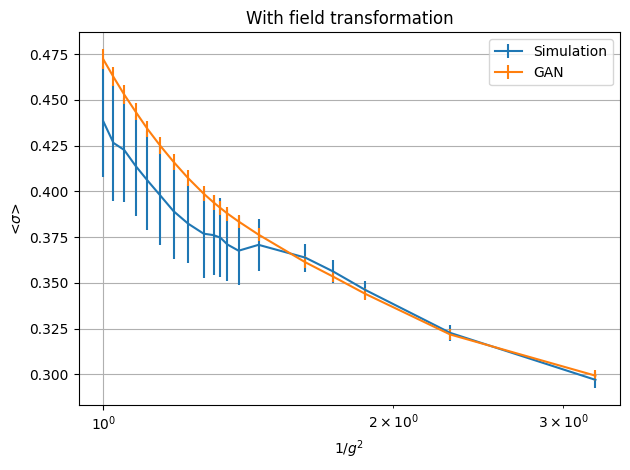

In [41]:
plt.errorbar(x = np.array(g)**(-0.5),y=sigma_mean_real,yerr=sigma_error_real, label = "Simulation")
plt.errorbar(x = np.array(g)**(-0.5),y=sigma_mean_fake,yerr=sigma_error_fake, label = "GAN")
plt.title("With field transformation")
plt.xlabel("$1/{g^2}$")
plt.ylabel("<$\sigma$>")
plt.grid()
plt.legend()
plt.xscale("log")
plt.tight_layout()
plt.savefig("2c.pdf")

In [ ]:
plt.errorbar(x = np.array(g)**(-0.5),y=sigma_mean_real,yerr=sigma_error_real, label = "Simulation")
plt.errorbar(x = np.array(g)**(-0.5),y=sigma_mean_fake,yerr=sigma_error_fake, label = "GAN")
plt.title("With field transformation")
plt.xlabel("$1/{g^2}$")
plt.ylabel("<$\sigma$>")
plt.grid()
plt.legend()
plt.xscale("log")
plt.tight_layout()
plt.savefig("2c.pdf")

In [1]:
plt.title("Error vs Epoch")
plt.plot(error_mse)
plt.xlabel("Epoch")
plt.ylabel("$MSE({<\sigma_K>} - {<\sigma_G>}$)")
plt.yscale("log")
plt.grid()

NameError: name 'plt' is not defined

In [31]:
gc.collect()

18429